### Import Libraries

In [1]:
import math
import os
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score

### Constants

In [2]:
COLORS = np.array(["red", "blue", "green", "orange", "pink", "salmon", "grey"])

### General Functions

In [3]:
def get_current_dt():
    current_dt = datetime.now()
    return current_dt.strftime('%Y-%m-%d %H:%M:%S')

def calculate_distance_matrix(t1: np.array, t2: np.array):
    dist_mat = np.abs(t1.reshape(-1, 1)-t2)
    return dist_mat

def save_result(df, file_name, base_path = './result'):
    # check if base path already exist
    if not os.path.exists(base_path):
        # if not, create the directory
        os.mkdir(base_path)
    
    file_path = f'{base_path}/{file_name}'

    # check if the file already exist
    is_file_exist = os.path.exists(file_path)
    if (is_file_exist):
        r = input('This file already exists, if you want to override please type "y"')
        if (r.lower() != 'y'):
            print(f'Cancel saving file to {file_path}')
            return
    df.to_csv(file_path, index = False)

## Import Dataset

In [4]:
def read_dataset_file(file_path):
    X = []
    y = []

    with open(file_path) as f:
        for line in f.readlines():
            line = line.strip()
            data = line.split()

            x_data = np.array([float(x) for x in data[1:]])
            y_data = int(float(data[0])) # the first value is the label (which is an integer)
            
            X.append(x_data)
            y.append(y_data)
    
    return X, pd.Series(y)

def import_dataset(dataset_name):
    X_train, y_train = read_dataset_file(f'./dataset/{dataset_name}/{dataset_name}_TRAIN')
    X_test, y_test = read_dataset_file(f'./dataset/{dataset_name}/{dataset_name}_TEST')

    print("=======================================")
    print(f'[{dataset_name} Dataset]')
    print(f'Number of Train Data = {len(y_train)}')
    print(f'Number of Test Data = {len(y_test)}')
    print(f'Number of classes = {len(y_train.unique())}: which are {sorted(y_train.unique())}')

    return X_train, y_train, X_test, y_test

def visualize_class_frequency(y_train: pd.Series, y_test: pd.Series, dataset_name = None, figsize = (8, 3)):
    fig, ax = plt.subplots(1, 2, figsize = figsize)
    
    title = f'{dataset_name if dataset_name is not None else ""} Class Distribution'
    fig.suptitle(title, fontsize = 12)

    for a in ax:
        a.set_xlabel('Class', fontsize = 10)
        a.set_ylabel('Number of Data', fontsize = 10)

    y_train.value_counts().sort_index().plot(kind = 'bar', ax = ax[0], color = COLORS)
    ax[0].set_title('Train Data', fontsize = 10)

    y_test.value_counts().sort_index().plot(kind = 'bar', ax = ax[1], color = COLORS)
    ax[1].set_title('Test Data', fontsize = 10)

    plt.show()

def visualize_time_series_dimension(X_train, X_test, dataset_name = None):
    fig, ax = plt.subplots(1, 2, figsize = (8, 3))

    title = f'{dataset_name if dataset_name is not None else ""} Length Distribution'
    fig.suptitle(title, fontsize = 12)

    train_length_list = []
    for i in range (len(X_train)):
        train_length_list.append(len(X_train[i]))

    test_length_list = []
    for i in range (len(X_test)):
        test_length_list.append(len(X_test[i]))

    ax[0].hist(train_length_list)
    ax[0].set_title('Train Data', fontsize = 10)

    ax[1].hist(test_length_list)
    ax[1].set_title('Test Data', fontsize = 10)

    plt.show()

def visualize_time_series_each_class(X, y: pd.Series, title = None, figsize = (8, 5)):
    n = len(X)

    plt.figure(figsize = figsize)
    for i in range(n):
        label = y[i]
        color_index = sorted(y.unique()).index(label) % len(COLORS)
        plt.plot(X[i], color = COLORS[color_index], label = label, linewidth = 0.5, alpha = 0.9)
    
    # remove duplicate labels in the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    if title is not None:
        plt.title(title)

    plt.show()

In [5]:
dataset_list = ['Gun_Point', 'Lightning7', 'synthetic_control', 'Coffee', 'FaceFour']
datasets = {}

for dataset_name in dataset_list:
    X_train, y_train, X_test, y_test = import_dataset(dataset_name)
    datasets[dataset_name] = {'X_train': X_train,
                             'y_train': y_train,
                             'X_test': X_test,
                             'y_test': y_test}

[Gun_Point Dataset]
Number of Train Data = 50
Number of Test Data = 150
Number of classes = 2: which are [1, 2]
[Lightning7 Dataset]
Number of Train Data = 70
Number of Test Data = 73
Number of classes = 7: which are [0, 1, 2, 3, 4, 5, 6]
[synthetic_control Dataset]
Number of Train Data = 300
Number of Test Data = 300
Number of classes = 6: which are [1, 2, 3, 4, 5, 6]
[Coffee Dataset]
Number of Train Data = 28
Number of Test Data = 28
Number of classes = 2: which are [0, 1]
[FaceFour Dataset]
Number of Train Data = 24
Number of Test Data = 88
Number of classes = 4: which are [1, 2, 3, 4]


[Gun_Point Dataset]


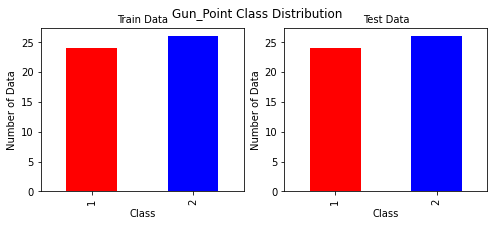

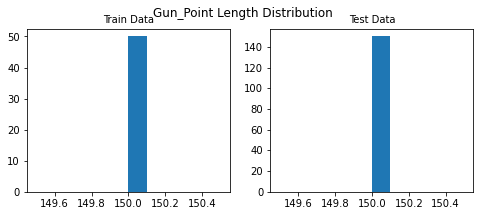

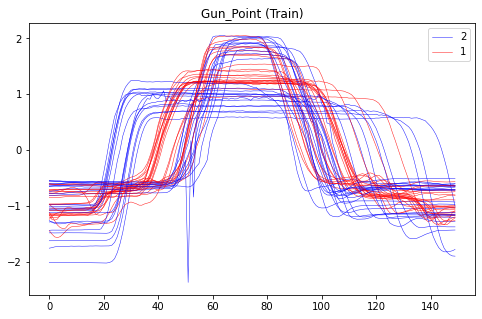

[Lightning7 Dataset]


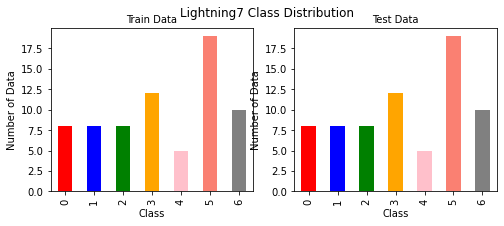

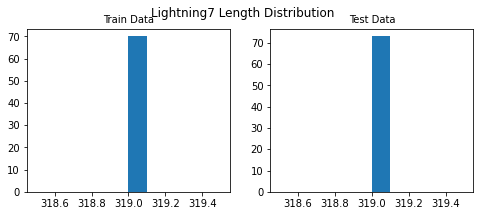

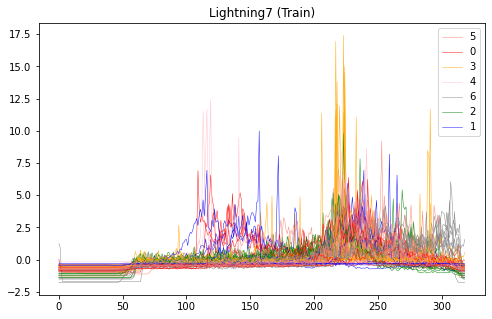

[synthetic_control Dataset]


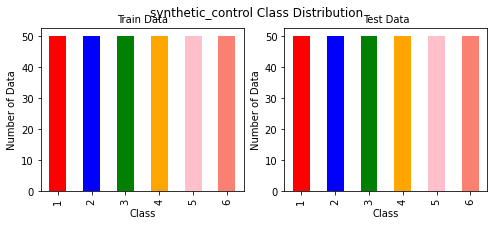

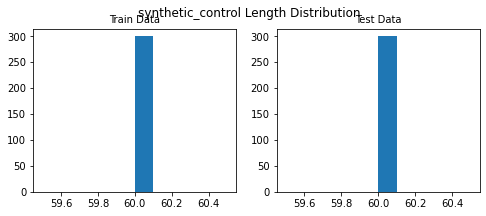

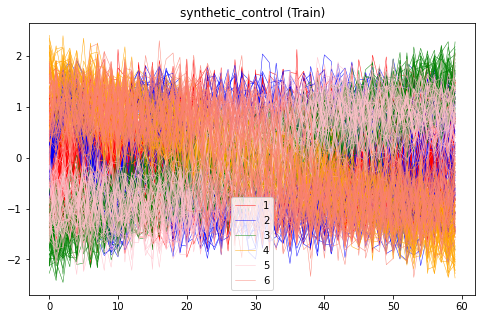

[Coffee Dataset]


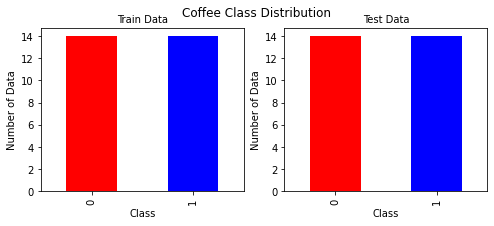

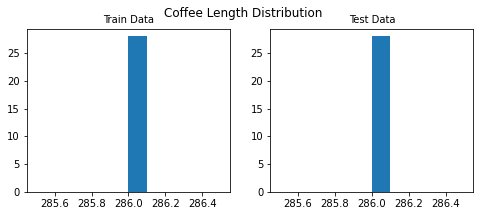

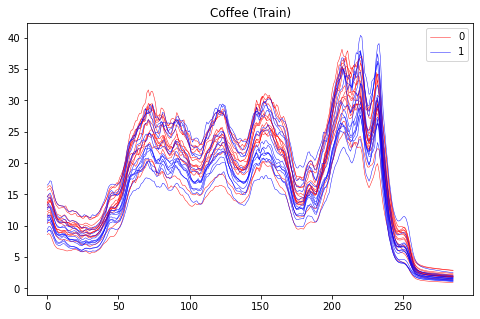

[FaceFour Dataset]


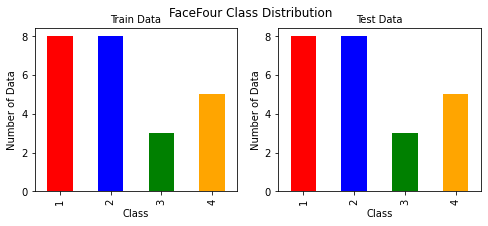

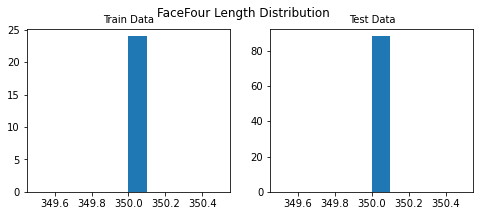

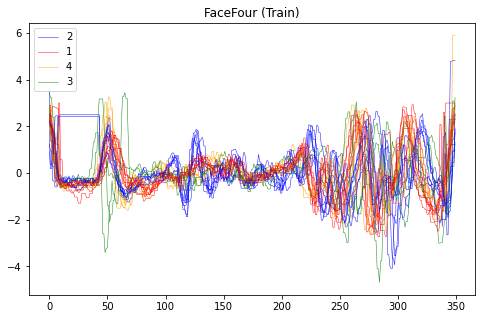

In [6]:
for dataset_name in dataset_list:
    X_train = datasets[dataset_name]['X_train']
    y_train = datasets[dataset_name]['y_train']
    X_test = datasets[dataset_name]['X_test']
    y_test = datasets[dataset_name]['y_train']

    print("==========================================================================")
    print(f'[{dataset_name} Dataset]')
    visualize_class_frequency(y_train, y_test, dataset_name = dataset_name)
    visualize_time_series_dimension(X_train, X_test, dataset_name = dataset_name)
    visualize_time_series_each_class(X_train, y_train, title = f'{dataset_name} (Train)')

## Dynamic Time Warping (DTW) Distance (with Sakoe-Chiba Band) Class 

In [7]:
class DTWDistance:
    def create_mask_sakoe_chiba_band(self, 
                                     N: int, 
                                     M: int,
                                     r: int):
        '''
        This function creates a numpy array of shape (N, M) where each element (i, j) in
        the array is either True or False. (will be True when (i, j) is within the sakoe-chiba band,
        otherwise False)
        [Input]
            N = length of the first time series (positive integer)
            M = length of the second time series (integer > 0)
            r = sakoe-chiba's window length (integer > 0)
        [Output]
            mask = boolean numpy array shape (N ,M)
        '''
        
        # generate x, y coordinates
        x = np.hstack([np.expand_dims(np.arange(0, N), axis = 0).T]*M)
        y = np.vstack([np.arange(0, M)]*N)

        # sakoe-chiba bands
        m = (M-1)/(N-1) #slope
        c = r*math.sqrt(m**2 + 1) #y-intercept

        # boolean mask
        mask = (y >= m*x-c) & (y <= m*x+c)

        return mask

    def fill_cost_matrix_p_n(self, 
                             cost_mat,
                             dist_mat,
                             dist_weight,
                             traceback_mat,
                             p, i, j):
        '''
        This function computes the minimum cost to be filled in the cost matrix at index (i, j)
        during computing the DTW distance using dynamic programming by obsering all possible paths given p 
        (slope constraint condition) 
        
        This function only accepts p only p = 0, 1, 2, ...
        For p is an integer, there can be only 3 paths which are

        g(i, j) = min {
            g(i-p, j-1-p) + w_00*d(i, j) + sum(k = 1 to p)(w_0k*d(i+1-k, j-k)), (Path #0)
            g(i-1, j-1) + w_10*d(i, j),                                         (Path #1)
            g(i-1-p, j-p) + w_20*d(i, j) + sum(k = 1 to p)(w_2k*d(i-k, j+1-k))  (Path #2)
        }

        where g = cost_mat, d = dist_mat, w = dist_weight

        [Input]
            cost_mat = cost matrix obtained from calculating DTW (2D numpy array shape (N, M))
            dist_mat = distance matrix obtained from calculating the distance between point i in the first time series and
                        point j in the second time series (2D numpy array shape (N, M))
            dist_weight = distance weight for calculating the minimum cost (2D numpy array shape (3, p+1))
            traceback_mat = traceback matrix (2D numpy array shape (N, M))
            p = slope constraint condition (integer: p = 0, 1, 2, ...)
            i, j = index of the cost matrix to be filled (0 <= i < N, 0 <= j < M)
        [Output]
            cost_mat = updated cost_mat (2D numpy array shape (N, M))
            traceback_mat = updatd traceback_mat (2D numpy array shape (N, M))
        '''
        
        dist_vector_0 = np.array([dist_mat[i,j] if k == 0 else dist_mat[i+1-k, j-k] for k in range (0, p+1)]) if i-p >= 0 and j-1-p >= 0 else None 
        dist_vector_1 = np.array([dist_mat[i, j]]) if i-1 >= 0 and j-1 >= 0 else None
        dist_vector_2 = np.array([dist_mat[i,j] if k == 0 else dist_mat[i-k, j+1-k] for k in range (0, p+1)]) if i-1-p >= 0 and j-p >= 0 else None

        cost_0 = np.dot(dist_vector_0, dist_weight[0, :]) + cost_mat[i-p, j-1-p] if dist_vector_0 is not None else np.inf
        cost_1 = np.dot(dist_vector_1, dist_weight[1, 0:1]) + cost_mat[i-1, j-1] if dist_vector_1 is not None else np.inf
        cost_2 = np.dot(dist_vector_2, dist_weight[2, ]) + cost_mat[i-1-p, j-p] if dist_vector_2 is not None else np.inf      
        
        cost_list = np.array([cost_0, cost_1, cost_2])

        if (cost_list == np.inf).sum() != 3:
            cost_mat[i, j] = np.min(cost_list)
            traceback_mat[i, j] = np.argmin(cost_list)

        return cost_mat, traceback_mat

    def fill_cost_matrix_p_half(self,
                                cost_mat,
                                dist_mat,
                                dist_weight,
                                traceback_mat,
                                i, j):
        '''
        Similar to fill_cost_matrix_p_n but only accept p = 1/2

        g(i, j) = min {
            g(i-1, j-3) + w_00*d(i, j) + w_01*d(i, j-1) + w_02*d(i, j-2),  (Path #0)
            g(i-1, j-2) + w_10*d(i, j) + w_11*d(i, j-1),                   (Path #1)
            g(i-1, j-1) + w_20*d(i, j),                                    (Path #2)             
            g(i-2, j-1) + w_30*d(i, j) + w_31*d(i-1, j),                   (Path #3)
            g(i-3, j-1) + w_40*d(i, j) + w_41*d(i-1, j) + w_42*d(i-2, j)   (Path #4)
        }
        '''

        cost_0 = cost_mat[i-1, j-3] + dist_weight[0, 0]*dist_mat[i, j] + dist_weight[0, 1]*dist_mat[i, j-1] + dist_weight[0, 2]*dist_mat[i, j-2] if i-1 >= 0 and j-3 >= 0 else np.inf
        cost_1 = cost_mat[i-1, j-2] + dist_weight[1, 0]*dist_mat[i, j] + dist_weight[1, 1]*dist_mat[i, j-1] if i-1 >= 0 and j-2 >= 0 else np.inf
        cost_2 = cost_mat[i-1, j-1] + dist_weight[2, 0]*dist_mat[i, j] if i-1 >= 0 and j-1 >= 0 else np.inf
        cost_3 = cost_mat[i-2, j-1] + dist_weight[3, 0]*dist_mat[i, j] + dist_weight[3, 1]*dist_mat[i-1, j] if i-2 >= 0 and j-1 >= 0 else np.inf
        cost_4 = cost_mat[i-3, j-1] + dist_weight[4, 0]*dist_mat[i, j] + dist_weight[4, 1]*dist_mat[i-1, j] + dist_weight[4, 2]*dist_mat[i-2, j] if i-3 >= 0 and j-1 >= 0 else np.inf

        cost_list = np.array([cost_0, cost_1, cost_2, cost_3, cost_4])

        if (cost_list == np.inf).sum() != 5:
            cost_mat[i, j] = np.min(cost_list)
            traceback_mat[i, j] = np.argmin(cost_list)

        return cost_mat, traceback_mat

    def traceback_p_n(self,
                      traceback_mat,
                      dist_weight,
                      p):
        '''
        This function tracebacks the warping path from the pre-calculated traceback_mat
        (This function only accepts p only p = 0, 1, 2, ...)
        '''

        # Start Trackback from the end (N-1, M-1) of the path back to the start (0, 0) of the path
        i = traceback_mat.shape[0] - 1
        j = traceback_mat.shape[1] - 1

        path = [(i, j)]
        tb_type = traceback_mat[i, j]
        sum_weight = dist_weight[1, 0]

        while tb_type != np.inf:
            tb_type = int(tb_type)
            if tb_type == 0:
                for k in range (1, p+1):
                    path.append((i+1-k, j-k))
                i = i-p
                j = j-1-p
            elif tb_type == 1:
                i = i-1
                j = j-1
            elif tb_type == 2:
                for k in range (1, p+1):
                    path.append((i-k, j+1-k))
                i = i-1-p
                j = j-p
            # initial case
            elif tb_type == 3:
                i = i-1
            elif tb_type == 4:
                j = j-1

            path.append((i, j))

            if (tb_type >= 0 and tb_type <= 2):
                sum_weight += dist_weight[tb_type, :][dist_weight[tb_type, :] != None].sum()
            elif tb_type == 3:
                sum_weight += dist_weight[2, 0]
            elif tb_type == 4:
                sum_weight += dist_weight[0, 0]

            tb_type = traceback_mat[i, j]

        return path[::-1], sum_weight
    
    def traceback_p_half(self,
                        traceback_mat,
                        dist_weight):
        '''
        Similar to traceback_p_n but only accept p = 1/2
        '''

        # Start Trackback from the end (N-1, M-1) of the path back to the start (0, 0) of the path
        i = traceback_mat.shape[0] - 1
        j = traceback_mat.shape[1] - 1

        # Path
        path = [(i, j)]
        tb_type = traceback_mat[i, j]
        sum_weight = dist_weight[2, 0]
        while tb_type != np.inf:
            tb_type = int(tb_type)
            if tb_type == 0:
                path.append((i, j-1))
                path.append((i, j-2))
                i = i-1
                j = j-3
            elif tb_type == 1:
                path.append((i, j-1))
                i = i-1
                j = j-2
            elif tb_type == 2:
                i = i-1
                j = j-1
            elif tb_type == 3:
                path.append((i-1, j))
                i = i-2
                j = j-1
            elif tb_type == 4:
                path.append((i-1, j))
                path.append((i-2, j))
                i = i-3
                j = j-1
            # initial case
            elif tb_type == 5:
                i = i-1
            elif tb_type == 6:
                j = j-1
            path.append((i, j))

            if (tb_type >= 0 and tb_type <= 4):
                sum_weight += dist_weight[tb_type, :][dist_weight[tb_type, :] != None].sum()
            elif tb_type == 5:
                sum_weight += dist_weight[4, 0]
            elif tb_type == 6:
                sum_weight += dist_weight[0, 0]

            tb_type = traceback_mat[i, j]

        return path[::-1], sum_weight

    def dp_p_n_sakoe_chiba(self,
                           dist_mat,
                           dist_weight,
                           p = 0, r = None):
        '''
        Find minimum-cost path through pre-calculated distance matrix `d` using dynamic programming.
        '''

        assert isinstance(p, int), "'p' is not an integer"
        assert p >= 0, f"p must be greater than or equal to 0, {p} is invalid"
        assert dist_weight.shape[0] == 3 and dist_weight.shape[1] == p+1, f"dist_weight shape {dist_weight.shape} is invalid"

        dist_mat = np.copy(dist_mat)

        # Obtain the length from each time series from the shape of the distance matrix
        # N = Length of the first time series
        # M = Length of the second time series
        N, M = dist_mat.shape

        # Initialize the cost matrix (g) and the traceback matrix (t)
        g = np.full((N, M), np.inf)
        t = np.full((N, M), np.inf)

        # Initial Condition    
        g[0, 0] = dist_weight[1, 0]*dist_mat[0, 0]

        # More Initial Condition (in case of p > 0):
        if (p > 0):
            for i in range (1, N):
                if (r is not None and i >= r*math.sqrt(((M-1)/(N-1))**2 + 1)*(N-1)/(M-1)):
                    break
                g[i, 0] = g[i-1, 0] + dist_weight[2, 0] * dist_mat[i, 0]
                t[i, 0] = 3

            for j in range (1, M):
                if (r is not None and j >= r*math.sqrt(((M-1)/(N-1))**2 + 1)):
                    break
                g[0, j] = g[0, j-1] + dist_weight[0, 0] + dist_mat[0, j]
                t[0, j] = 4

        # Fill the cost matrix while keeping traceback information
        if r is not None: 
            # Activate Sakoe-Chiba Band
            sakoe_chiba_mask = self.create_mask_sakoe_chiba_band(N, M, r)
            dist_mat[~sakoe_chiba_mask] = np.inf

            i = 0
            j = 0

            while True:
                j += 1
                if j > ((M-1)/(N-1))*i + r*math.sqrt(((M-1)/(N-1))**2 + 1) or j > M-1:
                    i += 1
                    if (i > N-1):
                        break
                    j = min(max(0, math.ceil(((M-1)/(N-1))*i - r*math.sqrt(((M-1)/(N-1))**2 + 1))), M-1)
                g, t = self.fill_cost_matrix_p_n(g, dist_mat, dist_weight, t, p, i, j)

        else: # Deactivate Sakoe-Chiba Band
            for i in range (N):
                for j in range (M):
                    if (i == 0 and j == 0):
                        continue
                    g, t = self.fill_cost_matrix_p_n(g, dist_mat, dist_weight, t, p, i, j)

        alignment_cost = g[N-1, M-1]

        # Path Traceback
        path, sum_weight = self.traceback_p_n(t, dist_weight, p)
        
        normalized_alignment_cost = alignment_cost / sum_weight
        return alignment_cost, normalized_alignment_cost, g, path

    def dp_p_half_sakoe_chiba(self,
                            dist_mat,
                            dist_weight,
                            r = None):
        assert dist_weight.shape[0] == 5 and dist_weight.shape[1] == 3, f"dist_weight shape {dist_weight.shape} is invalid"

        dist_mat = np.copy(dist_mat)

        # Obtain the length from each time series from the shape of the distance matrix
        # N = Length of the first time series
        # M = Length of the second time series
        N, M = dist_mat.shape

        # Initialize the cost matrix (g) and the traceback matrix (t)
        g = np.full((N, M), np.inf)
        t = np.full((N, M), np.inf)

        # Initial Condition:
        g[0, 0] = dist_weight[2, 0]*dist_mat[0, 0]

        # More Initial Condition
        for i in range (1, N):
            if (r is not None and i >= r*math.sqrt(((M-1)/(N-1))**2 + 1)*(N-1)/(M-1)):
                break
            g[i, 0] = g[i-1, 0] + dist_weight[4, 0] * dist_mat[i, 0]
            t[i, 0] = 5
        for j in range (1, M):
            if (r is not None and j >= r*math.sqrt(((M-1)/(N-1))**2 + 1)):
                break
            g[0, j] = g[0, j-1] + dist_weight[0, 0] + dist_mat[0, j]
            t[0, j] = 6
        
        # Fill the cost matrix while keeping traceback information
        if r is not None: 
            sakoe_chiba_mask = self.create_mask_sakoe_chiba_band(N, M, r)
            dist_mat[~sakoe_chiba_mask] = np.inf
            i = 0
            j = 0
            while True:
                j += 1
                if j > ((M-1)/(N-1))*i + r*math.sqrt(((M-1)/(N-1))**2 + 1) or  j > M-1:
                    i += 1
                    if (i > N-1):
                        break
                    j = min(max(0, math.ceil(((M-1)/(N-1))*i - r*math.sqrt(((M-1)/(N-1))**2 + 1))), M-1)
                g, t = self.fill_cost_matrix_p_half(g, dist_mat, dist_weight, t, i, j)
        else:
            for i in range (N):
                for j in range (M):
                    if (i == 0 and j == 0):
                        continue
                    g, t = self.fill_cost_matrix_p_half(g, dist_mat, dist_weight, t,  i, j)

        alignment_cost = g[N-1, M-1]

        # Path Traceback
        path, sum_weight = self.traceback_p_half(t, dist_weight)
        
        normalized_alignment_cost = alignment_cost / sum_weight
        return alignment_cost, normalized_alignment_cost, g, path
    
    # Wrapper function to call 'dp_p_n_sakoe_chiba' (p = 0, 1, 2, ...) or 'dp_p_half_sakoe_chiba' (p = 1/2) depends on the given p value. ***
    def dp_dtw_sakoe_chiba(self,
                           dist_mat,
                           dist_weight,
                           p, r):
        if isinstance(p, int):
            return self.dp_p_n_sakoe_chiba(dist_mat, dist_weight, p = p, r = r)
        elif p == 1/2:
            return self.dp_p_half_sakoe_chiba(dist_mat, dist_weight, r = r)
    # -----------------------------------------------------------------------------------------------------------------------------------------

## OneNearestNeighborClassifierDTW Class

In [8]:
class OneNearestNeighborClassifierDTW:
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.n_train = y_train.shape[0]
        self.dtwDistance = DTWDistance()

    def predict_single_item(self, X_test, dist_weight, p = 0, r = None):
        norm_distance = []
  
        for i in range (self.n_train):
            dist_mat = calculate_distance_matrix(X_test, self.X_train[i])
            alignment_cost, normalized_alignment_cost, cost_mat, path = self.dtwDistance.dp_dtw_sakoe_chiba(dist_mat, dist_weight, p = p, r = r)

            norm_distance.append(normalized_alignment_cost)

        norm_distance = np.array(norm_distance)
        closet_idx = np.argmin(norm_distance)
        predict_class = self.y_train[closet_idx]
        return predict_class, closet_idx, norm_distance
    
    def predict(self, X_test, dist_weight, p = 0, r = None, enable_tqdm = True):
        n_test = len(X_test)

        y_predict = []
        closet_idx = []

        if (enable_tqdm):
            for_range = tqdm(range(n_test))
        else:
            for_range = range(n_test)

        for i in for_range:
            y_predict_i, closet_idx_i, _ = self.predict_single_item(X_test[i], dist_weight, p = p, r = r)
            
            y_predict.append(y_predict_i)
            closet_idx.append(closet_idx_i)

        y_predict = np.array(y_predict)
        closet_idx = np.array(closet_idx)

        return y_predict, closet_idx

## Visualization Functions

In [9]:
def plot_two_time_series(t1, t2, path = None, figsize = (10, 4), title = None, show_value = False):
    SHIFT_VALUE = 1.5

    plt.figure(figsize = figsize)
    plt.plot(np.arange(t1.shape[0]), t1 + SHIFT_VALUE, "-o", c = "C3")
    plt.plot(np.arange(t2.shape[0]), t2 - SHIFT_VALUE, "-o", c = "C0")
    if show_value:
        for i in range(len(t1)):
            plt.text(i - 0.1, t1[i] + SHIFT_VALUE + 0.3, t1[i].round(2))
        for i in range(len(t2)):
            plt.text(i - 0.1, t2[i] - SHIFT_VALUE + 0.3, t2[i].round(2))
    if path is not None:
        for x_i, y_j in path:
            plt.plot([x_i, y_j], [t1[x_i] + SHIFT_VALUE, t2[y_j] - SHIFT_VALUE], c = "C7")
    if title is not None:
        plt.title(title)
    plt.axis("off")
    plt.show()

def plot_distance_and_cost_matrix(dist_mat, cost_mat, path = None, figsize = (8, 4)):
    dist_mat = dist_mat.T
    cost_mat = cost_mat.T

    # plot distance_matrix and cost_matrix
    fig, ax = plt.subplots(1, 2, figsize = figsize)

    # Plot distance matrix
    ax[0].set_title("Distance Matrix")
    ax[0].imshow(dist_mat, cmap = plt.cm.binary, origin = "lower")
    ax[0].set_xlabel("A")
    ax[0].set_ylabel("B")

    # Plot cost matrix and the alignment path
    ax[1].set_title("Cost Matrix")
    ax[1].set_xlabel("A")
    ax[1].set_ylabel("B")
    ax[1].imshow(cost_mat, cmap = plt.cm.binary, origin = "lower")
    if path is not None:
        x_path, y_path = zip(*path)
        plt.plot(x_path, y_path)
    plt.show()

def plot_cost_matrix_heatmap(cost_mat, path = None, figsize = (20, 10), annot = True, title = None, is_tick_visible = True, cmap = "YlGnBu"):
    cost_mat = cost_mat.T
    cost_mat_rounded = cost_mat.round(0)
    cost_mat_mask = (cost_mat == np.inf) # To be filtered out

    # Plot cost_mat as heatmap
    fig, ax = plt.subplots(figsize = figsize)
    ax = sns.heatmap(cost_mat_rounded, 
                     mask = cost_mat_mask, 
                     annot = annot, square = True, linewidths=0.1, cmap=cmap, annot_kws={"fontsize":5}, ax=ax, fmt='.3g')
    ax.invert_yaxis()

    if path is not None:
        # Get the warp path in x and y directions
        path_x = [p[0]+0.5 for p in path]
        path_y = [p[1]+0.5 for p in path]
        ax.plot(path_x, path_y, '-o', color='black', linewidth=1, alpha=0.5, markersize=2)

    if (is_tick_visible):
        plt.xticks(fontsize=8, rotation=90)
        plt.yticks(fontsize=8)
    else:
        plt.xticks([]) 
        plt.yticks([]) 

    plt.xlabel('First Time Series', fontsize=10)
    plt.ylabel('Second Time Series', fontsize=10)
    if title is None:
        title = 'Warping Path (DTW)'
    plt.title(title, fontsize=12)
    plt.show()

## Create a classifier for each dataset

In [10]:
classifiers = {}

for dataset_name in dataset_list:
    print(f'Create a classifier for dataset: {dataset_name}')
    classifiers[dataset_name] = OneNearestNeighborClassifierDTW(datasets[dataset_name]['X_train'], datasets[dataset_name]['y_train'])

Create a classifier for dataset: Gun_Point
Create a classifier for dataset: Lightning7
Create a classifier for dataset: synthetic_control
Create a classifier for dataset: Coffee
Create a classifier for dataset: FaceFour


## Symmetric Weight for Dynamic Time Warping

In [11]:
WEIGHT_P_N_SYMMETRIC = [np.array([ #p = 0
        [1],
        [2],
        [1]]), 
     np.array([ #p = 1
        [1, 2],
        [2, None],
        [1, 2]]),
     np.array([ #p = 2
        [1, 2, 2],
        [2, None, None],
        [1, 2, 2]]),
      np.array([ #p = 3
        [1, 2, 2, 2],
        [2, None, None, None],
        [1, 2, 2, 2]])    
]

WEIGHT_P_HALF_SYMMETRIC = np.array([ #p = 1/2
    [1, 1, 2],
    [1, 2, None],
    [2, None, None],
    [1, 2, None],
    [1, 1, 2]
])

def get_dtw_symmetric_weight_p(p):
    dist_weight = None
    if isinstance(p, int):
        dist_weight = WEIGHT_P_N_SYMMETRIC[p]
    elif p == 1/2:
        dist_weight = WEIGHT_P_HALF_SYMMETRIC
    return dist_weight

# Experiment

## Experment Functions

In [12]:
def experiment_window_size(t1, t2, dist_mat, r_list = None, title = None):
    p_list = [0, 1/2, 1, 2, 3]

    if (r_list is None):
        r_list = [0, 1] + list(range(2, max(abs(len(t1)-len(t2)), min(len(t1), len(t2))//4), 2))

    dtwDistance = DTWDistance()

    for p in p_list:
        distance_list = []

        # Assume: using symetric weight for all p values in this function
        dist_weight = get_dtw_symmetric_weight_p(p)
        
        for r in r_list:
            _, normalized_alignment_cost, _, _ = dtwDistance.dp_dtw_sakoe_chiba(dist_mat, dist_weight, p = p, r = r)
            distance_list.append(normalized_alignment_cost)
        
        plt.plot(r_list, distance_list, "-o", label = f'p = {p}')
    plt.legend(loc=(1.04, 0.40))
    plt.title(title)
    plt.xlabel("Window size (r)")
    plt.ylabel("DTW Normalized Distance")
    plt.show()

def visualize_path_alignment(t1, t2, dist_mat, p, r, dist_weight = None, use_symmetric_weight = True, heatmap_annot = False, heatmap_figsize = (18, 8), heatmap_cmap = "YlGnBu", is_tick_visible = False):
    dtwDistance = DTWDistance()

    if use_symmetric_weight:
        if isinstance(p, int):
            dist_weight = WEIGHT_P_N_SYMMETRIC[p]
        elif p == 1/2:
            dist_weight = WEIGHT_P_HALF_SYMMETRIC

    alignment_cost, normalized_alignment_cost, cost_mat, path = dtwDistance.dp_dtw_sakoe_chiba(dist_mat, dist_weight, p = p, r = r)

    print(f'p = {p}, r = {r}')
    print(f'Normalized DTW Distance = {round(normalized_alignment_cost, 4)}')
    plot_two_time_series(t1, t2, path = path, figsize = (7, 3))
    plot_distance_and_cost_matrix(dist_mat, cost_mat, path = path, figsize = (10, 3))

    heatmap_title = f'Warping Path (DTW), p = {p}'
    heatmap_title += f', r = {r}' if r is not None else ''
    plot_cost_matrix_heatmap(cost_mat, path, annot = heatmap_annot, title = heatmap_title, figsize = heatmap_figsize, is_tick_visible = is_tick_visible, cmap = heatmap_cmap)

## Experiment with Simple Time Series

In [13]:
# t1 = np.array([0, 2, 0, 1, 0, 0])
# t2 = np.array([0, 0, 0.5, 2, 0, 1, 0, 1,])

#============================================================================

# t1 = np.array([0, 2, 0, 1, 0, 0])
# t2 = np.array([0, 0, 0.5, 2, 0, 1, 0, 1, 2, 1, 0.5, 2, 0, 1, 0.5, 0, 0.25])

#=============================================================================

# f1 = 10
# f2 = 15

# x1 = np.linspace(0, 1, 20)
# x2 = x1[0: 15]

# A = np.sin(f1*x1)
# B = np.cos(f2*x2)

#=============================================================================

# I = np.linspace(0, 1, 20) 
# J = I[0: 15] 

# A = 3 * np.sin(np.pi * I) + 1.5 * np.sin(4*np.pi * I)
# B = 3 * np.sin(np.pi * J + 0.5) + 1.5 * np.sin(4*np.pi * J + 0.5)

# =============================================================================

np.random.seed(2023)

I = np.linspace(0, 2, 20)
J = np.linspace(0, 1, 15)

A = 1.5 * np.sin(1 * np.pi * I) + np.random.normal(loc = 0, scale = 0.3, size = 20)
B = 1.5 * np.sin(2 * np.pi * J) + np.random.normal(loc = 0, scale = 0.3, size = 15)



Distance Matrix (dist_mat):
Shape: (20, 15)
[[0.52358186 0.01332971 0.54536714 1.18755336 1.44152729 0.90489251
  0.6688483  0.00895499 0.46689885 1.25446327 1.84325598 1.39777005
  1.56646726 1.3202522  0.4156967 ]
 [0.69978351 0.18953137 0.36916549 1.01135171 1.26532563 0.72869085
  0.49264664 0.16724667 0.64310051 1.43066493 2.01945763 1.57397171
  1.74266892 1.49645386 0.23949504]
 [0.93083767 0.42058553 0.13811133 0.78029755 1.03427147 0.49763669
  0.26159248 0.39830083 0.87415467 1.66171909 2.25051179 1.80502587
  1.97372308 1.72750802 0.00844088]
 [1.63670475 1.1264526  0.56775575 0.07443047 0.3284044  0.20823039
  0.4442746  1.10416791 1.58002174 2.36758617 2.95637887 2.51089295
  2.67959016 2.43337509 0.6974262 ]
 [1.73353224 1.22328009 0.66458324 0.02239702 0.23157691 0.30505788
  0.54110209 1.2009954  1.67684924 2.46441366 3.05320636 2.60772044
  2.77641765 2.53020259 0.79425369]
 [1.46256875 0.9523166  0.39361975 0.24856647 0.5025404  0.03409439
  0.27013859 0.93003191 1.4

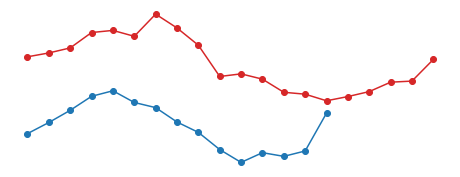

In [14]:
dist_mat = calculate_distance_matrix(A, B)

print(f'\nDistance Matrix (dist_mat):')
print(f'Shape: {dist_mat.shape}')
print(dist_mat)

plot_two_time_series(A, B, figsize = (8, 3), show_value = False)

### Window Size (r)

In [15]:
# experiment_window_size(A, B, dist_mat, r_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], title = None)

### Visualize the alignment with specific p, r value

In [16]:
# p = 0
# r = None

# heatmap_annot = True

# visualize_path_alignment(A, B, dist_mat, p, r, heatmap_annot = heatmap_annot, heatmap_figsize = (15, 5), is_tick_visible = True)

Weight (a, b, c) = (1, 1, 1)
p = 0, r = None
Normalized DTW Distance = 0.2567


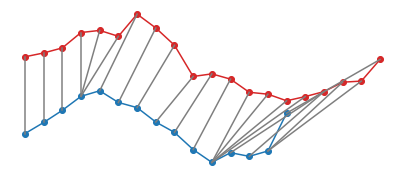

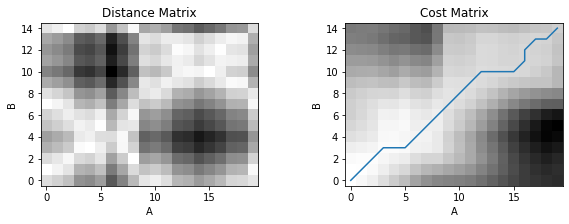

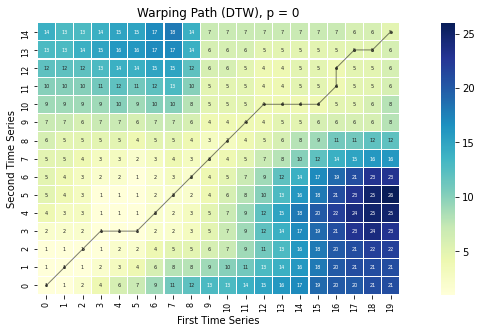

Weight (a, b, c) = (1, 2, 1)
p = 0, r = None
Normalized DTW Distance = 0.2454


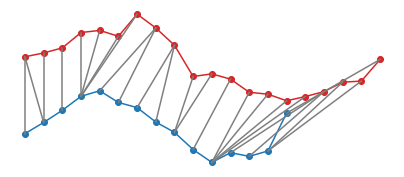

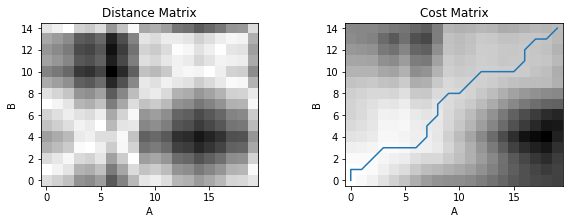

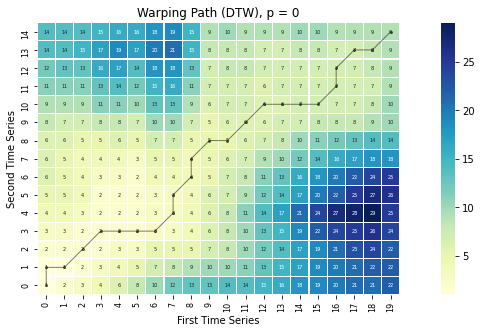

Weight (a, b, c) = (1, 0.5, 1)
p = 0, r = None
Normalized DTW Distance = 0.248


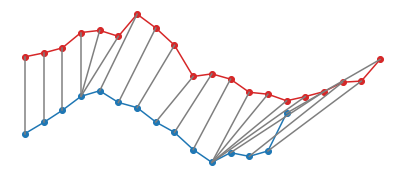

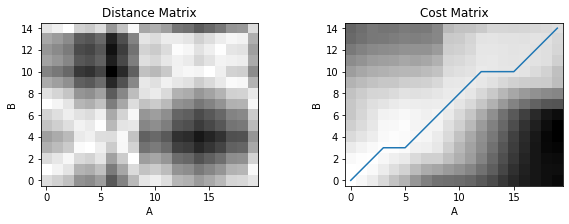

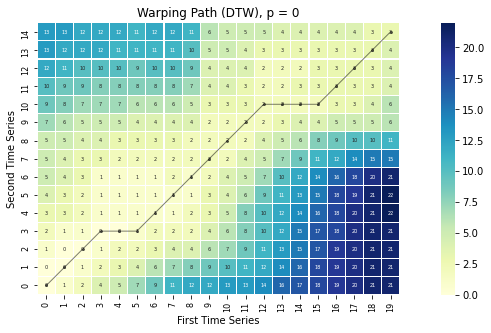

Weight (a, b, c) = (0.5, 1, 0.5)
p = 0, r = None
Normalized DTW Distance = 0.2454


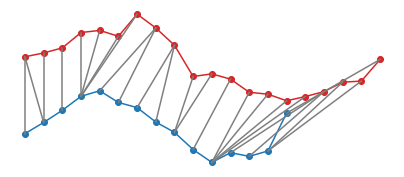

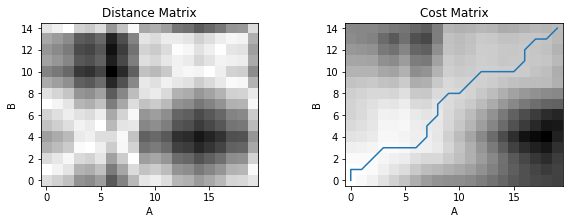

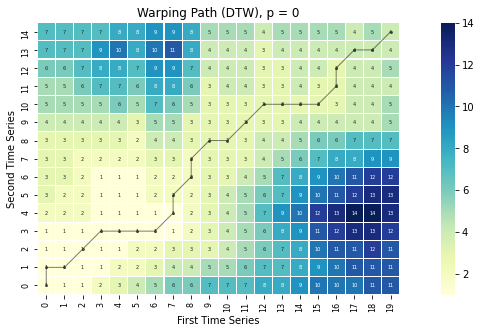

Weight (a, b, c) = (1, 1, 0)
p = 0, r = None
Normalized DTW Distance = 0.2073


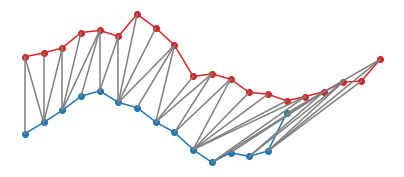

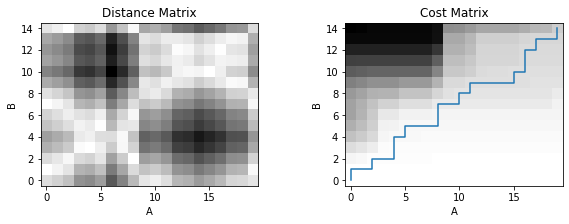

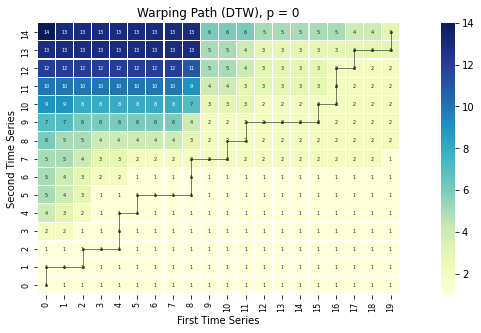

Weight (a, b, c) = (0, 1, 1)
p = 0, r = None
Normalized DTW Distance = 0.2209


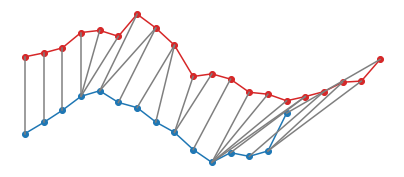

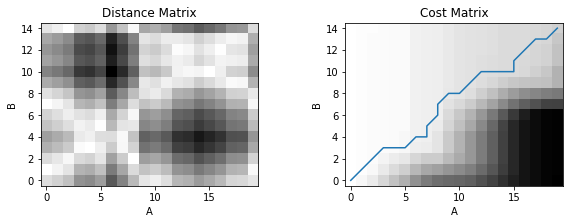

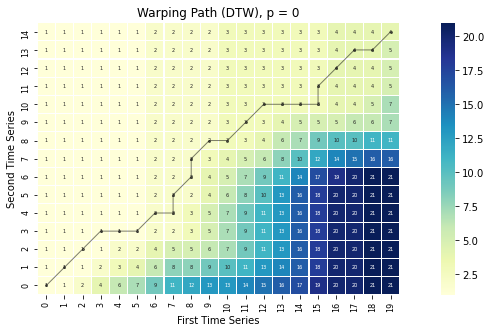

Weight (a, b, c) = (2, 1, 0.5)
p = 0, r = None
Normalized DTW Distance = 0.2383


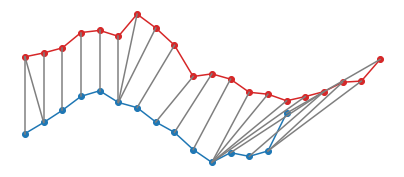

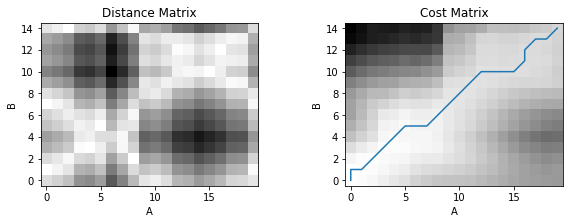

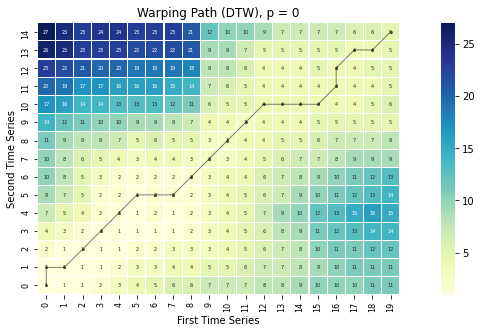

Weight (a, b, c) = (0.5, 1, 2)
p = 0, r = None
Normalized DTW Distance = 0.2329


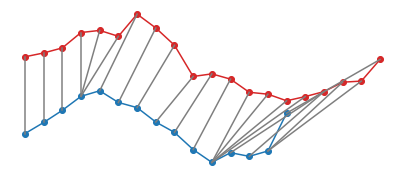

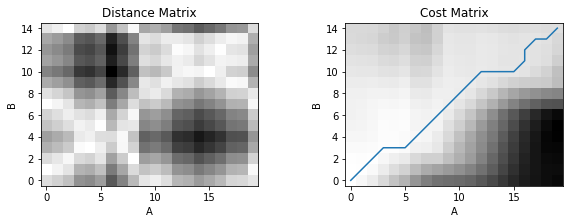

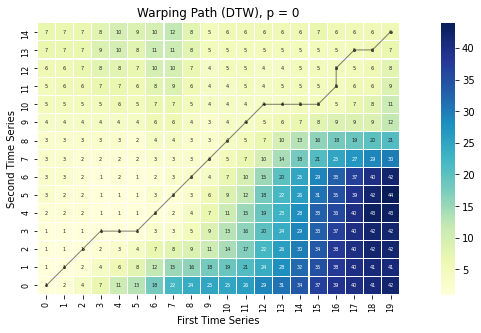

In [17]:
WEIGHTS_TO_EXPERIMENT = [(1, 1, 1),
                         (1, 2, 1),
                         (1, 0.5, 1),
                         (0.5, 1, 0.5),
                         (1, 1, 0),
                         (0, 1, 1),            
                         (2, 1, 0.5),
                         (0.5, 1, 2),
                        ] 
p = 0
r = None

heatmap_annot = True

for (a, b, c) in WEIGHTS_TO_EXPERIMENT:
    w = np.array([
        [a],
        [b],
        [c]
    ])

    print("=======================================================")
    print(f"Weight (a, b, c) = ({a}, {b}, {c})")
    visualize_path_alignment(A, B, dist_mat, p, r, heatmap_annot = heatmap_annot, heatmap_figsize = (15, 5), is_tick_visible = True, 
                             use_symmetric_weight = False, dist_weight = w)
    

### D(A, B) = D(B, A) ?

In [18]:
WEIGHTS_TO_EXPERIMENT = [(1, 1, 1),
                         (1, 2, 1),
                         (1, 0.5, 1),
                         (0.5, 1, 0.5),
                         (1, 1, 0),
                         (0, 1, 1),            
                         (2, 1, 0.5),
                         (0.5, 1, 2),
                        ] 

dist_mat_AB = calculate_distance_matrix(A, B)
dist_mat_BA = calculate_distance_matrix(B, A)
p = 0
r = None
dtwDistance = DTWDistance()

for (a, b, c) in WEIGHTS_TO_EXPERIMENT:
    w = np.array([
        [a],
        [b],
        [c]
    ])

    _, normalized_alignment_cost_AB, _, _ = dtwDistance.dp_dtw_sakoe_chiba(dist_mat_AB, w, p = p, r = r)
    _, normalized_alignment_cost_BA, _, _ = dtwDistance.dp_dtw_sakoe_chiba(dist_mat_BA, w, p = p, r = r)

    print(f"Weight (a, b, c) = ({a}, {b}, {c}): D(A, B) = {round(normalized_alignment_cost_AB, 4)}, D (B, A) = {round(normalized_alignment_cost_BA, 4)}")

Weight (a, b, c) = (1, 1, 1): D(A, B) = 0.2567, D (B, A) = 0.2567
Weight (a, b, c) = (1, 2, 1): D(A, B) = 0.2454, D (B, A) = 0.2454
Weight (a, b, c) = (1, 0.5, 1): D(A, B) = 0.248, D (B, A) = 0.248
Weight (a, b, c) = (0.5, 1, 0.5): D(A, B) = 0.2454, D (B, A) = 0.2454
Weight (a, b, c) = (1, 1, 0): D(A, B) = 0.2073, D (B, A) = 0.2209
Weight (a, b, c) = (0, 1, 1): D(A, B) = 0.2209, D (B, A) = 0.2073
Weight (a, b, c) = (2, 1, 0.5): D(A, B) = 0.2383, D (B, A) = 0.2329
Weight (a, b, c) = (0.5, 1, 2): D(A, B) = 0.2329, D (B, A) = 0.2383


## Experiment with Dataset

synthetic_control Dataset
t1: Train ID: 1, Time Series Length = 60, Label = 1, 
t2: Test ID: 3, Time Series Length = 60, Label = 1

Distance Matrix (dist_mat):
Shape: (60, 60)
[[0.53944797 0.41458139 0.76880479 ... 0.0936726  0.43939061 0.47293869]
 [0.3083109  0.64571846 0.99994186 ... 0.32480967 0.20825354 0.70407576]
 [0.96723673 1.92126609 2.27548949 ... 1.6003573  1.06729409 1.97962339]
 ...
 [1.29318206 0.3391527  0.0150707  ... 0.66006149 1.1931247  0.2807954 ]
 [0.01921616 0.97324552 1.32746892 ... 0.65233673 0.11927352 1.03160282]
 [0.07996082 1.03399018 1.38821358 ... 0.7130814  0.18001818 1.09234748]]


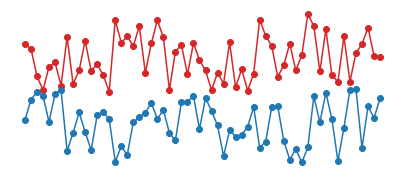

In [19]:
# [SETTINGS] ======================================
dataset_to_experiment = 'synthetic_control'
# dataset_to_experiment = 'FaceFour'

# train_id_sample = 1
# test_id_sample = 3

train_id_sample = 1
test_id_sample = 3
# ==================================================

classifier = classifiers[dataset_to_experiment]

t1 = datasets[dataset_to_experiment]['X_train'][train_id_sample] 
label_t1 = datasets[dataset_to_experiment]['y_train'][train_id_sample]

t2 = datasets[dataset_to_experiment]['X_test'][test_id_sample]
label_t2 = datasets[dataset_to_experiment]['y_test'][test_id_sample]

dist_mat = calculate_distance_matrix(t1, t2)

print(f'{dataset_to_experiment} Dataset')
print(f't1: Train ID: {train_id_sample}, Time Series Length = {len(t1)}, Label = {label_t1}, ')
print(f't2: Test ID: {test_id_sample}, Time Series Length = {len(t2)}, Label = {label_t2}')
print(f'\nDistance Matrix (dist_mat):')
print(f'Shape: {dist_mat.shape}')
print(dist_mat)

plot_two_time_series(t1, t2, figsize = (7, 3))

### Window Size (r)

Experimenting with window size = [1, 2, 3, 4, 5, 6, 8, 10, 12, 13, 15, 17, 19, 21, 22, 24]


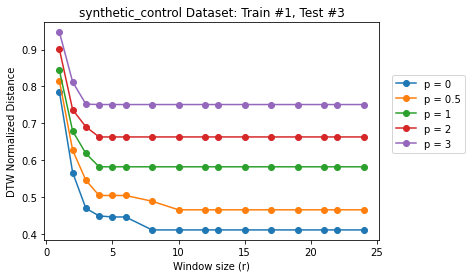

In [20]:
r_list = sorted(set([1, 2, 3, 4, 5]).union(set([int(e) for e in list(np.arange(0.05, 0.42, 0.03)*len(t1))])))
print(f'Experimenting with window size = {r_list}')

experiment_window_size(t1, t2, dist_mat, 
                       title = f'{dataset_to_experiment} Dataset: Train #{train_id_sample}, Test #{test_id_sample}',
                       r_list = r_list)

### Visualize the alignment with specific p, r value

p = 0, r = 6
Normalized DTW Distance = 0.446


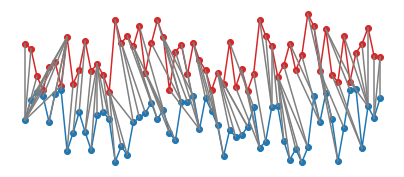

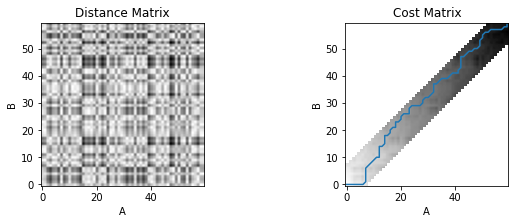

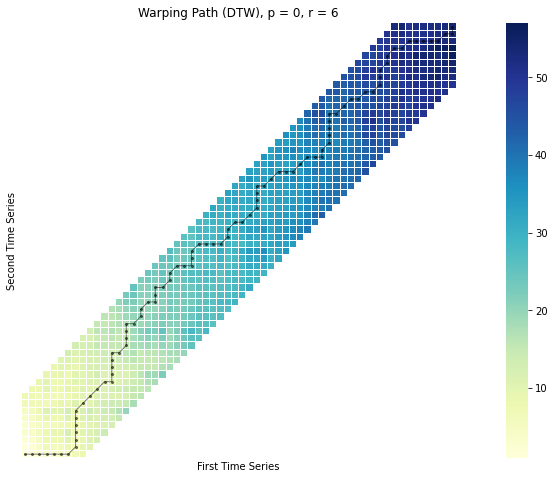

In [21]:
p = 0
r = 6
heatmap_annot = False
heatmap_cmap = "YlGnBu"

visualize_path_alignment(t1, t2, dist_mat, p, r, heatmap_annot = heatmap_annot, heatmap_cmap = heatmap_cmap)

### Small p VS Large p (slope constraint condition)
Use symmetric weight provided in paper for all p values

p = 0, r = None
Normalized DTW Distance = 0.4109


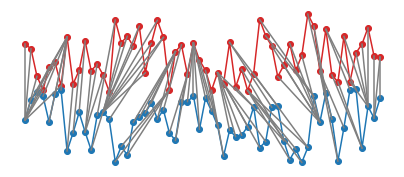

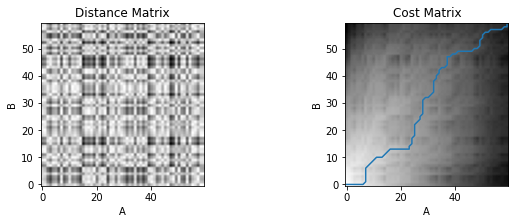

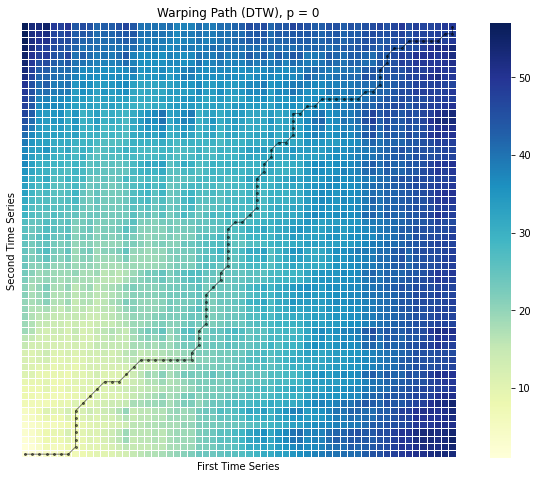

p = 0.5, r = None
Normalized DTW Distance = 0.4654


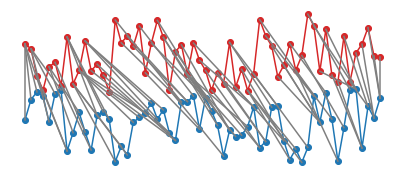

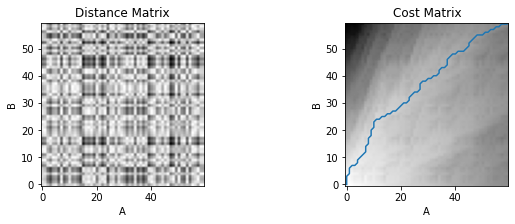

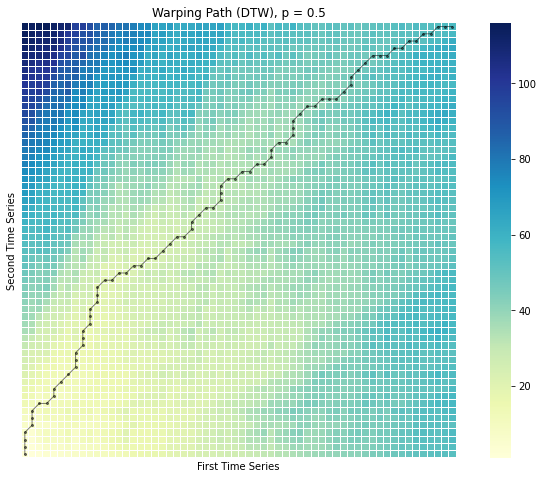

p = 1, r = None
Normalized DTW Distance = 0.582


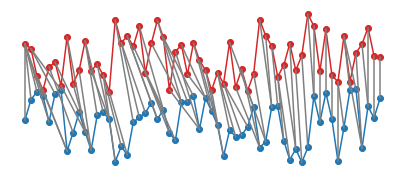

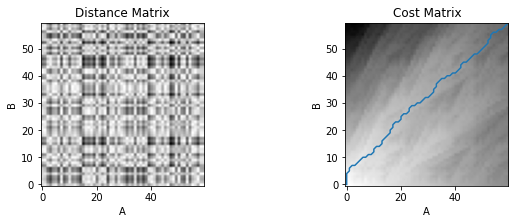

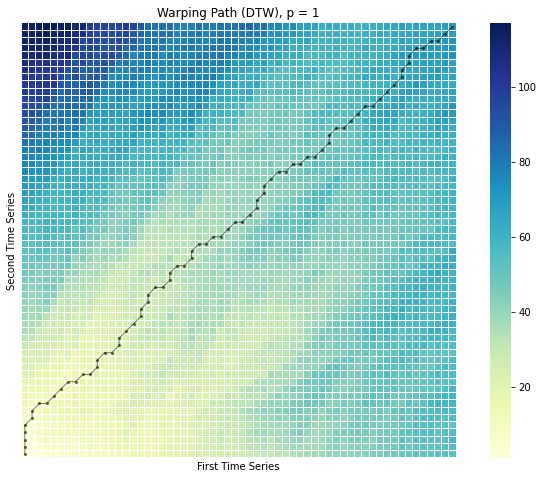

p = 2, r = None
Normalized DTW Distance = 0.663


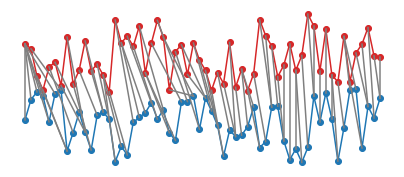

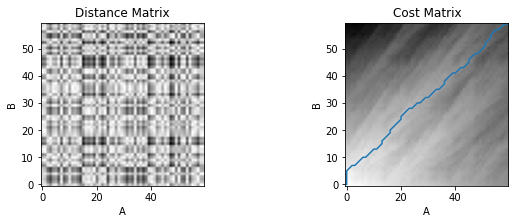

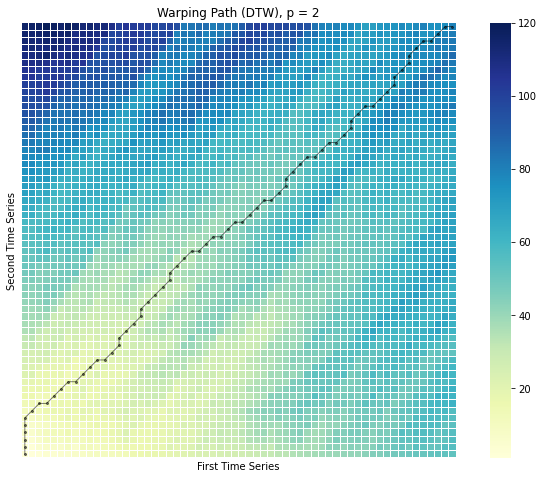

p = 3, r = None
Normalized DTW Distance = 0.7509


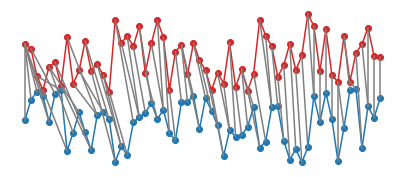

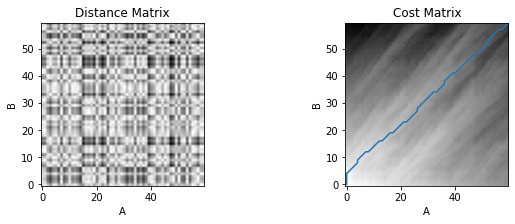

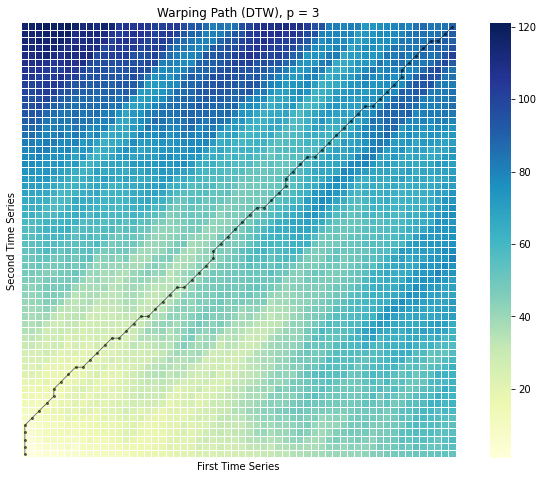

p = inf
Normalized DTW Distance = 1.2427


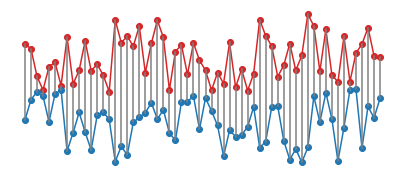

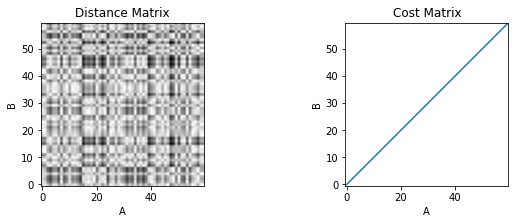

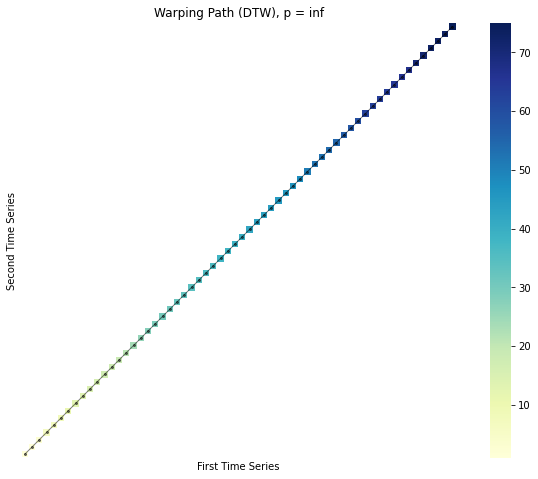

In [22]:
# [SETTINGS] ========================
p_list = [0, 1/2, 1, 2, 3]
r = None
heatmap_annot = False
heatmap_figsize = (12, 8)
# ===================================

distance_list = []
distaince_inf = None

for p in p_list:
    # assume using symmetric weight for all p values
    dist_weight = get_dtw_symmetric_weight_p(p)
    alignment_cost, normalized_alignment_cost, cost_mat, path = classifier.dtwDistance.dp_dtw_sakoe_chiba(dist_mat, dist_weight, p = p, r = r)
    distance_list.append(normalized_alignment_cost)
    visualize_path_alignment(t1, t2, dist_mat, p, r, heatmap_annot = heatmap_annot, heatmap_figsize = heatmap_figsize)
    print("===============================================================================")

# p = inf case (this wonly works when t1 and t2 have the same length)
if (len(t1) == len(t2)):
    path_inf = [(i, i) for i in range(len(t1))] # path = diagonal line
    cost_mat_inf = np.full(dist_mat.shape, np.inf)
    cost_mat_inf[np.diag_indices_from(cost_mat_inf)] = np.cumsum(dist_mat[np.diag_indices_from(dist_mat)])

    distance_inf = round(cost_mat_inf[-1, -1] / len(t1), 4)

    print(f'p = inf')
    print(f'Normalized DTW Distance = {distance_inf}')

    plot_two_time_series(t1, t2, path = path_inf, figsize = (7, 3))
    plot_distance_and_cost_matrix(dist_mat, cost_mat_inf, path = path_inf, figsize = (10, 3))

    heatmap_title = f'Warping Path (DTW), p = inf'
    plot_cost_matrix_heatmap(cost_mat_inf, path = path_inf, annot = heatmap_annot, title = heatmap_title, figsize = heatmap_figsize, is_tick_visible = False)

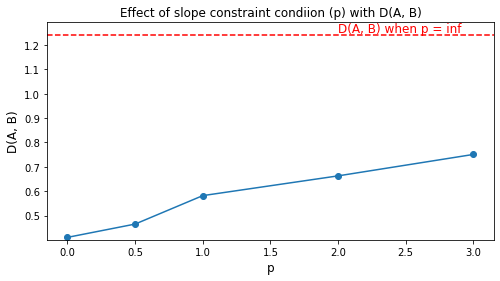

In [23]:
plt.figure(figsize = (8, 4))
plt.plot(p_list, distance_list, '-o')

if distance_inf is not None:
    plt.axhline(y = distance_inf, linestyle = '--', color = 'red')
    plt.text(x = p_list[-2], y = distance_inf + 0.01, s = 'D(A, B) when p = inf', fontsize = 12, color = 'red')
    plt.ylim([min(distance_list) - 0.01, max(max(distance_list), distance_inf) + 0.05])
plt.xlabel('p', fontsize = 12)

plt.ylabel('D(A, B)', fontsize = 12)
plt.title('Effect of slope constraint condiion (p) with D(A, B)', fontsize = 12)
plt.show()


### Case p = 0: Symmetric Weight VS Asymmetric Weight

Weight: (1, 1, 1)


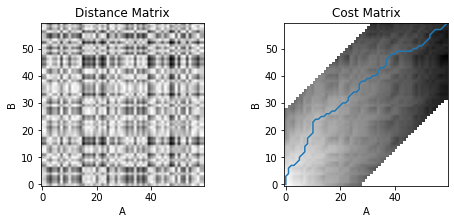

Weight: (1, 2, 1)


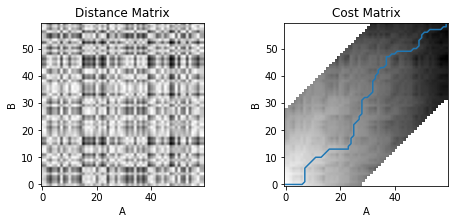

Weight: (1, 0.5, 1)


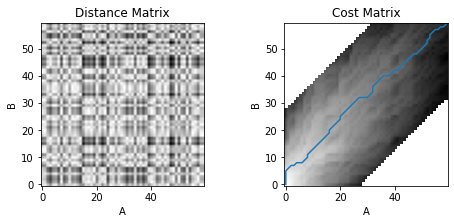

Weight: (0.5, 1, 0.5)


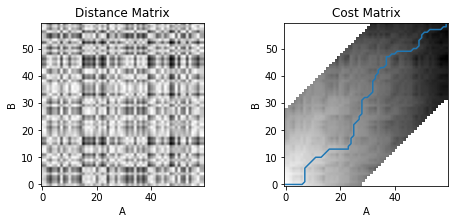

Weight: (1, 1, 0)


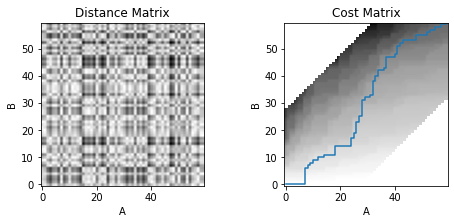

Weight: (0, 1, 1)


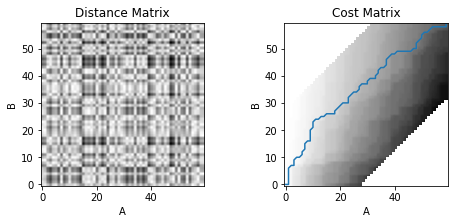

Weight: (2, 1, 0.5)


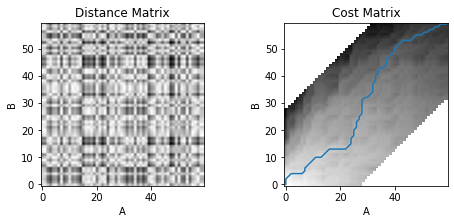

Weight: (0.5, 1, 2)


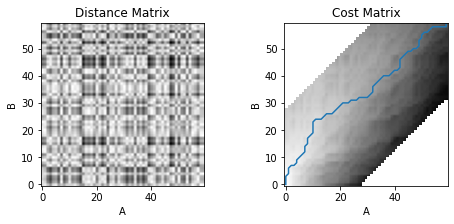

In [24]:
# [SETTINGS] ===================================================
# dataset_to_experiment = 'Gun_Point'
# dataset_to_experiment = 'Lightning7'
dataset_to_experiment = 'synthetic_control'
# dataset_to_experiment = 'Coffee'
# dataset_to_experiment = 'FaceFour'
WEIGHTS_TO_EXPERIMENT = [(1, 1, 1),
                         (1, 2, 1),
                         (1, 0.5, 1),
                         (0.5, 1, 0.5),
                         (1, 1, 0),
                         (0, 1, 1),            
                         (2, 1, 0.5),
                         (0.5, 1, 2),
                        ] 
r = 20
# ==============================================================

classifier = classifiers[dataset_to_experiment]

for (a, b, c) in WEIGHTS_TO_EXPERIMENT:
    w = np.array([
        [a],
        [b],
        [c]
    ])

    alignment_cost, normalized_alignment_cost, cost_mat, path = classifier.dtwDistance.dp_p_n_sakoe_chiba(dist_mat, w, p = 0, r = r)
    print(f'Weight: {(a, b, c)}')
    plot_distance_and_cost_matrix(dist_mat, cost_mat, path = path, figsize = (8, 3))

### 1-Nearest Neighbor Classification

p = 0, r = 6


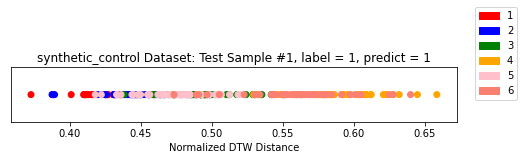

In [26]:
# [SETTINGS] =========================================================
# dataset_to_experiment = 'Gun_Point'
# dataset_to_experiment = 'Lightning7'
dataset_to_experiment = 'synthetic_control'
# dataset_to_experiment = 'Coffee'
# dataset_to_experiment = 'FaceFour'
test_id_sample = 1
p = 0
r = 6
use_symmetric_weight = True
dist_weight = np.array([
            [1],
            [2],
            [1]])
# ===================================================================

classifier = classifiers[dataset_to_experiment]
test_sample = datasets[dataset_to_experiment]['X_test'][test_id_sample]
test_label = datasets[dataset_to_experiment]['y_test'][test_id_sample]
dataset_unique_label = sorted(datasets[dataset_to_experiment]['y_train'].unique())

if use_symmetric_weight:
    if isinstance(p, int):
        dist_weight = WEIGHT_P_N_SYMMETRIC[p]
    elif p == 1/2:
        dist_weight = WEIGHT_P_HALF_SYMMETRIC

predict_sample, closet_idx, distance = classifier.predict_single_item(test_sample, dist_weight, p = p, r = r)

plt.figure(figsize = (8, 1))

color_l = []

plt.scatter( distance, [0] * distance.shape[0], color = COLORS[datasets[dataset_to_experiment]['y_train'].apply(lambda x: dataset_unique_label.index(x))])

plt.ylim([-0.01, 0.01])
plt.title(f'{dataset_to_experiment} Dataset: Test Sample #{test_id_sample}, label = {test_label}, predict = {predict_sample}')
plt.xlabel('Normalized DTW Distance')
plt.yticks([])

patches = []
for i in range(len(dataset_unique_label)):
    patches.append(mpatches.Patch(color=COLORS[i], label= dataset_unique_label[i]))
plt.legend(handles=patches, loc=(1.04, 0.40))

print(f'p = {p}, r = {r}')
plt.show()

# No. 1) Experiment on weight of the three neighboring cells

$
g(i, j) = 
\begin{cases}
g(i, j-1) + {\color{Yellow} a}d(i, j)\\
g(i-1, j-1) + {\color{Lime} b}d(i, j)\\
g(i-1, j) + {\color{Pink} c}d(i, j)
\end{cases}
$

In [27]:
def determine_symmetric_weight(weight):
    a, b, c = weight
    if (a == c):
        return 'symmetric'
    else:
        return 'asymmetric'

def create_csv_weight_report(weight_list, accuracy_list):
    df = pd.DataFrame()
    df['(a, b, c)'] = weight_list
    df['weight_symmetric'] = df.apply(lambda row: determine_symmetric_weight(row['(a, b, c)']), axis = 1)
    df['accuracy_score'] = accuracy_list

    return df

def weight_experiment(classifier, X_test, y_test, WEIGHTS, p = 0, r = None):
    accuracy_list = []

    for i in range(len(WEIGHTS)):
        print("======================================================")
        print(f'[{get_current_dt()}] Start Computing weight = {WEIGHTS[i]}')

        a, b, c = WEIGHTS[i]
        w = np.array([
            [a],
            [b],
            [c]
        ])

        y_predict, _ = classifier.predict(X_test, w, p = p, r = r)
        acc = accuracy_score(y_test, y_predict)
        print(f'[{get_current_dt()}] Finish: Accuracy Score = {acc.round(4)}')

        accuracy_list.append(acc)
    
    df = create_csv_weight_report(WEIGHTS, accuracy_list)
    return df

In [49]:
# [SETTINGS] ==========================================
# (a, b, c)
WEIGHTS_TO_EXPERIMENT = [(1, 1, 1),
                         (1, 2, 1),
                         (1, 0.5, 1),
                         (1, 1, 0),
                         (0, 1, 1),            
                         (2, 1, 0.5),
                         (0.5, 1, 2),
                        ] 

# dataset_to_experiment = 'Gun_Point'
# dataset_to_experiment = 'Lightning7'
# dataset_to_experiment = 'synthetic_control'
# dataset_to_experiment = 'Coffee'
dataset_to_experiment = 'FaceFour'
p = 0 #fixed
r = 28
# ====================================================

classifier = classifiers[dataset_to_experiment]
print(f'{dataset_to_experiment} Dataset')
print(f'Using p = {p} and r = {r}')
df_experiment_result = weight_experiment(classifier, 
                                         X_test=datasets[dataset_to_experiment]['X_test'],
                                         y_test=datasets[dataset_to_experiment]['y_test'],
                                         WEIGHTS=WEIGHTS_TO_EXPERIMENT,
                                         p=p, r=r)

df_experiment_result

FaceFour Dataset
Using p = 0 and r = 28
[2023-04-25 16:30:30] Start Computing weight = (1, 1, 1)


100%|██████████| 88/88 [29:00<00:00, 19.78s/it]


[2023-04-25 16:59:31] Finish: Accuracy Score = 0.8182
[2023-04-25 16:59:31] Start Computing weight = (1, 2, 1)


100%|██████████| 88/88 [23:07<00:00, 15.77s/it]


[2023-04-25 17:22:39] Finish: Accuracy Score = 0.8409
[2023-04-25 17:22:39] Start Computing weight = (1, 0.5, 1)


100%|██████████| 88/88 [19:27<00:00, 13.27s/it]


[2023-04-25 17:42:06] Finish: Accuracy Score = 0.7614
[2023-04-25 17:42:06] Start Computing weight = (1, 1, 0)


100%|██████████| 88/88 [20:17<00:00, 13.84s/it]


[2023-04-25 18:02:24] Finish: Accuracy Score = 0.4773
[2023-04-25 18:02:24] Start Computing weight = (0, 1, 1)


100%|██████████| 88/88 [20:28<00:00, 13.96s/it]


[2023-04-25 18:22:52] Finish: Accuracy Score = 0.8409
[2023-04-25 18:22:52] Start Computing weight = (2, 1, 0.5)


100%|██████████| 88/88 [19:12<00:00, 13.10s/it]


[2023-04-25 18:42:05] Finish: Accuracy Score = 0.7159
[2023-04-25 18:42:05] Start Computing weight = (0.5, 1, 2)


100%|██████████| 88/88 [19:17<00:00, 13.16s/it]

[2023-04-25 19:01:23] Finish: Accuracy Score = 0.8523


,"(a, b, c)",weight_symmetric,accuracy_score
0,"(1, 1, 1)",symmetric,0.818182
1,"(1, 2, 1)",symmetric,0.840909
2,"(1, 0.5, 1)",symmetric,0.761364
3,"(1, 1, 0)",asymmetric,0.477273
4,"(0, 1, 1)",asymmetric,0.840909
5,"(2, 1, 0.5)",asymmetric,0.715909
6,"(0.5, 1, 2)",asymmetric,0.852273


In [50]:
# [SETTINGS] ======================================
file_name = f'{dataset_to_experiment}_1_r_{r if r is not None else "inf"}.csv'
base_path = './result'
# ==================================================

save_result(df_experiment_result,
            file_name=file_name,
            base_path=base_path)

# No 2.) Experiment on using other cells rather than the three neighboring cells

In [51]:
def p_experiment(classifier, X_test, y_test, P_LISTS, r = None):
    accuracy_list = []

    for p in P_LISTS:
        print('======================================================')
        print(f'[{get_current_dt()}] Start Computing p = {p}')

        # use symmetric weight
        dist_weight = get_dtw_symmetric_weight_p(p)

        y_predict, _ = classifier.predict(X_test, dist_weight, p = p, r = r)
        acc = accuracy_score(y_test, y_predict)
        print(f'[{get_current_dt()}] Finish: Accuracy Score = {acc.round(4)}')

        accuracy_list.append(acc)

    df = pd.DataFrame()
    df['p'] = P_LISTS
    df['accuracy_score'] = accuracy_list

    return df
    

In [52]:
# [SETTINGS] ==========================================
P_LISTS = [1/2, 1, 2, 3]
# dataset_to_experiment = 'Gun_Point'
# dataset_to_experiment = 'Lightning7'
# dataset_to_experiment = 'synthetic_control'
# dataset_to_experiment = 'Coffee'
dataset_to_experiment = 'FaceFour'
r = 28
# ====================================================
classifier = classifiers[dataset_to_experiment]
print(f'{dataset_to_experiment} Dataset')

df_experiment_result = p_experiment(classifier,
                                    X_test=datasets[dataset_to_experiment]['X_test'],
                                    y_test=datasets[dataset_to_experiment]['y_test'],
                                    P_LISTS=P_LISTS,
                                    r = r)

df_experiment_result

FaceFour Dataset
[2023-04-25 19:01:23] Start Computing p = 0.5


100%|██████████| 88/88 [16:15<00:00, 11.08s/it]


[2023-04-25 19:17:38] Finish: Accuracy Score = 0.8295
[2023-04-25 19:17:38] Start Computing p = 1


100%|██████████| 88/88 [22:02<00:00, 15.03s/it]


[2023-04-25 19:39:41] Finish: Accuracy Score = 0.8068
[2023-04-25 19:39:41] Start Computing p = 2


100%|██████████| 88/88 [24:44<00:00, 16.87s/it]


[2023-04-25 20:04:25] Finish: Accuracy Score = 0.8295
[2023-04-25 20:04:25] Start Computing p = 3


100%|██████████| 88/88 [23:37<00:00, 16.11s/it]

[2023-04-25 20:28:03] Finish: Accuracy Score = 0.8636


,p,accuracy_score
0,0.5,0.829545
1,1.0,0.806818
2,2.0,0.829545
3,3.0,0.863636


In [53]:
# [SETTINGS] ======================================
file_name = f'{dataset_to_experiment}_2_r_{r if r is not None else "inf"}.csv'
base_path = './result'
# ==================================================

save_result(df_experiment_result,
            file_name=file_name,
            base_path=base_path)